In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import skmixed
from skmixed.lme.models import LinearLMESparseModel

In [3]:
!pwd

/Users/aksh/Storage/repos/skmixed/examples


In [4]:
data_path = Path("/Users/aksh/Storage/repos/covid-data/covid-19/seir-pipeline-outputs/")
covariates_version = "2020_05_09.01.10"
regression_version = "vis_test_3"
betas_path = data_path / 'regression' / regression_version / "betas"
coefficients_path = data_path / 'regression' / regression_version / "coefficients" / "coefficients_0.csv"
reg_settings_path = data_path / 'regression' / regression_version / "settings.json"
covariates_path = data_path / 'covariate' / covariates_version / "cached_covariates.csv"
cov_metadata_path = data_path / 'covariate' / covariates_version / "metadata.yaml"
location_metadata_path = data_path / 'metadata_inputs' / 'location_metadata_0.csv'

In [5]:
covariates_df = pd.read_csv(covariates_path)
coefficients_df = pd.read_csv(coefficients_path)
groups = set(coefficients_df['group_id'].unique())
betas_df = {group: pd.read_csv(betas_path/f'{group}'/'regression_draw_0.csv') for group in groups}
reg_settings = json.load(open(reg_settings_path))
covariates = list(reg_settings['covariates'].keys())
# covariates.remove("intercept")

In [10]:
all_betas = pd.concat(betas_df.values(), axis=0)
all_betas["std"] = 0.1
X = all_betas[["location_id"] + covariates + ["std"]].to_numpy()
columns_labels = [0] + (len(covariates)-1)*[3] + [4]
y = all_betas["beta"].to_numpy()

In [12]:
model = LinearLMESparseModel(lb=0, lg=0)
model.fit(X, y, columns_labels=columns_labels)
logger = model.logger_
all_betas["prediction"] = model.predict(X, columns_labels=columns_labels)

AssertionError: len(columns_labels) != x.shape[1] (not all columns are labelled)

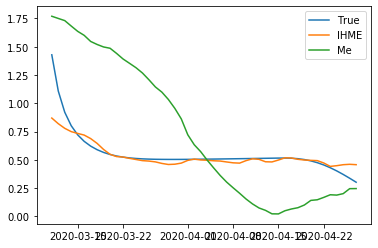

In [8]:
group = 523
cur_betas = all_betas[all_betas["location_id"] == group]
time = pd.to_datetime(cur_betas['date'])
plt.plot(time, cur_betas["beta"], label='True')
plt.plot(time, cur_betas["beta_pred"], label='IHME')
plt.plot(time, cur_betas["prediction"], label="Me")
plt.legend()

In [13]:
model.coef_

{'beta': array([ 1.50653863e+01, -3.24156166e-02,  2.05353252e-02, -2.00749016e+01,
        -1.18926611e+02,  7.47866770e+00]),
 'gamma': array([4.19835588e+02, 6.63940918e+01, 2.78534994e+08, 1.49006278e+02,
        1.19391940e+00, 4.19835588e+02]),
 'tbeta': array([  15.06538627,    0.        ,    0.        ,  -20.07490162,
        -118.92661064,    0.        ]),
 'tgamma': array([419.83558837,   0.        ,   0.        , 149.00627818,
          1.1939194 ,   0.        ]),
 'random_effects': array([[ 4.44501811e+01, -3.13807975e-01, -3.73012489e-03,
          9.61086748e+00, -4.47390708e-04,  4.44501811e+01],
        [ 2.77727287e+01, -1.96528449e-01, -1.36924430e-02,
          6.08236729e+00,  3.27892300e-04,  2.77727287e+01],
        [-1.41882406e+00, -6.00792015e-03,  2.29904211e-02,
         -1.55064353e-01, -1.02650879e-03, -1.41882406e+00],
        ...,
        [-7.78079593e-01, -1.24909221e-02,  2.79734777e-04,
         -9.46856560e-02, -7.13592375e-03, -7.78079593e-01],
     

In [18]:
list(all_betas.columns)

['index',
 'loc_id',
 'date',
 'days',
 'beta',
 'S',
 'E',
 'I1',
 'I2',
 'R',
 'newE',
 'newE_obs',
 'location_id',
 'temperature',
 'mobility_lift',
 'proportion_over_1k',
 'testing_reference',
 'intercept',
 'beta_pred',
 'std',
 'prediction']